<a href="https://colab.research.google.com/github/jacobdichter/testhub/blob/main/job_board_scrapenscore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## basic init
Importing Libraries and a few helper functions.

In [ ]:
!pip install selenium
!apt install chromium-chromedriver -y -q
!pip install sentence_transformers
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By

def start_browser():
  chrome_options = webdriver.ChromeOptions()
  chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  #chrome_options.add_argument('--disable-dev-shm-usage')
  browser = webdriver.Chrome(options=chrome_options)
  #browser.set_window_size(48, 32)
  return(browser)



from google.colab import userdata
userdata.get('HF_TOKEN')

import torch
from sentence_transformers import SentenceTransformer
dev_count = torch.cuda.device_count()
if dev_count>0:
  gpu=True
  torch.set_default_device('cuda')
  print("Using Device: "+ torch.cuda.get_device_properties(dev_count-1).name)

browser = start_browser()

## Heavy music playing.... Here comes HR_A_Tron.

In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer
import warnings
np.random.seed(42069)
warnings.filterwarnings('ignore')

# Features as in "lines of the document".
# Helps with large documents that need to be broken into chunks.
def get_features(doc, line_size=10):
    # todo: replace pandas with numpy
    split = doc.split("\n")
    if len(split)<10:
        split = doc.split(".")
    doc = pd.Series(split)
    doc = doc.apply(lambda x: x.replace("  ", ""))
    doc = doc[(doc.apply(lambda x: len(x.split()) > line_size))]
    return doc

# I have a few good ways to make this actually awesome. Open to suggestions.
class HR_A_Tron:

    def __init__(self, model='all-mpnet-base-v2', chunk_size=0, lex_size=1500):
        self.model = SentenceTransformer(model)
        self.lex_size = lex_size
        if chunk_size == 0:
            self.chunk_size = self.model.get_sentence_embedding_dimension() // 2
        else:
            self.chunk_size = chunk_size
        self.res = None

    def set_model(self, model_name):
        self.model = SentenceTransformer(model_name)

    def get_encoding(self, indoc, chunk_size=380):
        text = indoc.split("\n")
        outdoc = [' '.join(text[i:i + chunk_size]) for i in range(0, len(text), chunk_size)]
        x = self.model.encode(outdoc[0])
        for line in outdoc[1::]:
            x = np.hstack((x, self.model.encode(line)))
        return x

    def score(self, description, res):
        if type(description) is str:
            a = self.model.encode(description)
            t = self.model.encode(res)
            score = np.dot(a,t)
        else:
            a = description.map(self.model.encode)
            t = self.model.encode(res)
            score = a.apply(lambda x: np.dot(x, t))
        return score

    def feature_analysis(self, res, doc):

        reslines = get_features(res)
        doclines = get_features(doc)

        res_tokens = np.apply_along_axis(self.model.encode, 0, reslines)
        doc_tokens = np.apply_along_axis(self.model.encode, 0, doclines)

        match_matrix = np.apply_along_axis(lambda x: np.apply_along_axis(lambda y: np.dot(x, y), 1, doc_tokens), 1,
                                           res_tokens)

        renamer = np.vectorize(lambda x: " ".join(x.split()[0:5]) + "...")
        reslines = renamer(reslines)
        doclines = renamer(doclines)

        match_matrix = pd.DataFrame(match_matrix, index=reslines, columns=doclines)
        return match_matrix

    def plot_compare(self, matrix):
        import matplotlib.pyplot as plt
        import seaborn as sns
        f, ax = plt.subplots(nrows=3, ncols=1, figsize=(6, 24))
        for axis in [0, 1]:
            dat = matrix.sum(axis=axis).sort_values(ascending=False)
            y = dat.index
            x = dat.values
            sns.barplot(x=x, y=y, ax=ax[axis])
            ax[axis].set(xlabel="Relative Match")
            sns.despine(left=True, bottom=True)

        sns.heatmap(matrix, cmap="jet", ax=ax[2])


hr = HR_A_Tron()

## Load the target webpage

In [ ]:
browser.get('https://ai-jobs.net/?cou=238&key=&exp=EN#')

this part is experimental - I'm unsure what the best way is to load more, how I made it work the times it did and why it won't do more. I'm not a js person (yet).

In [ ]:
!pip install bs4
from bs4 import BeautifulSoup as bs

In [ ]:
soup = bs(browser.page_source, 'html.parser')

In [ ]:
soup.find_all("script")

400

In [ ]:
js = """
$(function(){
  // direct apply
  var countApplyClick = function(id) {
    $.post({
      headers: { "X-CSRFToken": "BPX5lHfSW6F5bg0DD2nhL9GiaNRyhfTCnMX9HBwK5udlEBIoedgiVs6wuk3FGaeP" },
      url: "/stats/event/",
      data: { evt: "c", app: "jobs", mdl: "job", oid: id }
    });
  }
  $(".btn-direct-apply").click(function(ev) {
    countApplyClick(ev.currentTarget.id)
  });
});"""

In [ ]:
browser.execute_script(js)

In [ ]:
len(browser.find_elements(By.CSS_SELECTOR, link_selector))

400

This may or may not work?

In [ ]:
link_selector = "#job-list > li > div > a"

for n in range(3):
    try:
        browser.find_element(By.CSS_SELECTOR, 'h2[class="h4 text-primary"').click()
    except:
        try:
            browser.find_element(By.CSS_SELECTOR, 'h2[class="h4 text-primary"').click()
        except:
            pass
    finally:
      print(len(browser.find_elements(By.CSS_SELECTOR, link_selector)))

100
100
100


In [ ]:
name_selector = "div > a > h2"
company_selector = "div > a > p"

links = []
for n in browser.find_elements(By.CSS_SELECTOR, link_selector):
    links.append(n.get_attribute('href'))

df = pd.DataFrame(links, columns=['link'])
del links

names = []
for name in browser.find_elements(By.CSS_SELECTOR, name_selector):
    names.append(name.text.strip())
df["name"] = names
del names

companies = []
for company in browser.find_elements(By.CSS_SELECTOR, company_selector):
    companies.append(company.text.strip())
df["company"] = companies
del companies

def get_description(l):
  try:
    browser.get(l)
    desc = browser.find_element(By.CSS_SELECTOR, 'body').text
    return desc
  except:
    return "NaN"

df['desc'] = df['link'].map(get_description)
df.head()

,link,name,company
0,https://ai-jobs.net/job/121433-postdoctoral-fe...,Postdoctoral Fellow: AI for Biochemistry,Lawrence Berkeley National Lab
1,https://ai-jobs.net/job/138776-clinical-data-a...,Clinical Data Analyst,Natera
2,https://ai-jobs.net/job/138466-lead-ml-ops-eng...,Lead ML Ops Engineer,Klaviyo
3,https://ai-jobs.net/job/138824-research-engine...,Research Engineering/ Scientist Associate I,The University of Texas at Austin
4,https://ai-jobs.net/job/138729-lead-data-engin...,Lead Data Engineer (P2759),84.51°
...,...,...,...
395,https://ai-jobs.net/job/136358-data-scientist-...,Data Scientist (Qualitative),Baylor College of Medicine
396,https://ai-jobs.net/job/136603-machine-learnin...,Machine Learning Engineer,Novo Nordisk
397,https://ai-jobs.net/job/136402-generative-ai-e...,"Generative AI Engineer, Senior",Booz Allen Hamilton
398,https://ai-jobs.net/job/136581-data-analyst-gl...,"Data Analyst, Global Learning Management",John Deere


# Scoring
## Get my resume from my website

In [ ]:
browser.get("https://gbwiersum.wixsite.com/website")
res = browser.find_element(By.CSS_SELECTOR, "#comp-lrxylkw6").text

In [ ]:
df["encoded"] = df["desc"].map(hr.model.encode)

In [ ]:
renc = hr.model.encode(res)

In [ ]:
df["score"]=df["encoded"].apply(lambda x: np.dot(renc, x))
std = df["score"].std()
mean = df["score"].mean()
df["score"] = df["score"].apply(lambda x: (x-mean)/std)

(array([ 11.,  23.,  29., 105., 119.,  68.,  31.,   7.,   5.,   2.]),
 array([-2.72150066, -2.08568309, -1.44986552, -0.81404794, -0.17823037,
         0.4575872 ,  1.09340478,  1.72922235,  2.36503992,  3.0008575 ,
         3.63667507]),
 <BarContainer object of 10 artists>)

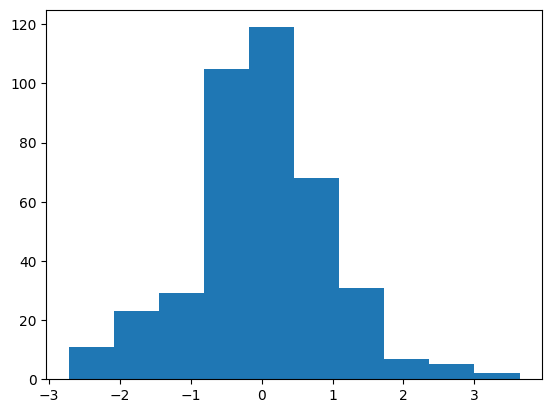

In [ ]:
import matplotlib.pyplot as plt
plt.hist(df["score"])

# And check out the results

In [ ]:
df.sort_values(by="score", ascending=False).head(10)

,link,name,company,desc,encoded,score
0,https://ai-jobs.net/job/121433-postdoctoral-fe...,Postdoctoral Fellow: AI for Biochemistry,Lawrence Berkeley National Lab,ai-jobs.net\nSearch\nEmails\nSaved\nProfile\nS...,"[0.028232511, 0.05448639, -0.030719522, -0.046...",3.636675
3,https://ai-jobs.net/job/138824-research-engine...,Research Engineering/ Scientist Associate I,The University of Texas at Austin,ai-jobs.net\nSearch\nEmails\nSaved\nProfile\nS...,"[0.031802196, 0.08493835, -0.015376011, -0.061...",3.121229
279,https://ai-jobs.net/job/136160-quantitative-ge...,Quantitative Genetics /Computational Biology I...,Inari Agriculture,ai-jobs.net\nSearch\nEmails\nSaved\nProfile\nS...,"[0.015718687, 0.07803737, -0.038073752, -0.038...",2.776140
179,https://ai-jobs.net/job/136160-quantitative-ge...,Quantitative Genetics /Computational Biology I...,Inari Agriculture,ai-jobs.net\nSearch\nEmails\nSaved\nProfile\nS...,"[0.015718687, 0.07803737, -0.038073752, -0.038...",2.776140
379,https://ai-jobs.net/job/136160-quantitative-ge...,Quantitative Genetics /Computational Biology I...,Inari Agriculture,ai-jobs.net\nSearch\nEmails\nSaved\nProfile\nS...,"[0.015718687, 0.07803737, -0.038073752, -0.038...",2.776140
81,https://ai-jobs.net/job/136762-staff-research-...,"Staff Research Scientist, AI/ML",Chan Zuckerberg Initiative,ai-jobs.net\nSearch\nEmails\nSaved\nProfile\nS...,"[0.041506447, 0.08897264, -0.04163643, -0.0604...",2.648935
1,https://ai-jobs.net/job/138776-clinical-data-a...,Clinical Data Analyst,Natera,ai-jobs.net\nSearch\nEmails\nSaved\nProfile\nS...,"[0.035735175, 0.08824572, -0.046795525, -0.082...",2.377814
357,https://ai-jobs.net/job/136346-senior-nlp-data...,Senior NLP Data Science Researcher (PhD Requir...,John Snow Labs,ai-jobs.net\nSearch\nEmails\nSaved\nProfile\nS...,"[0.05949858, 0.09195922, -0.040999662, -0.0384...",2.290300
157,https://ai-jobs.net/job/136346-senior-nlp-data...,Senior NLP Data Science Researcher (PhD Requir...,John Snow Labs,ai-jobs.net\nSearch\nEmails\nSaved\nProfile\nS...,"[0.05949858, 0.09195922, -0.040999662, -0.0384...",2.290300
257,https://ai-jobs.net/job/136346-senior-nlp-data...,Senior NLP Data Science Researcher (PhD Requir...,John Snow Labs,ai-jobs.net\nSearch\nEmails\nSaved\nProfile\nS...,"[0.05949858, 0.09195922, -0.040999662, -0.0384...",2.290300


# Visualizing what makes a job a match
I like having a few neutral, non-matching sections that can be used as a baseline.

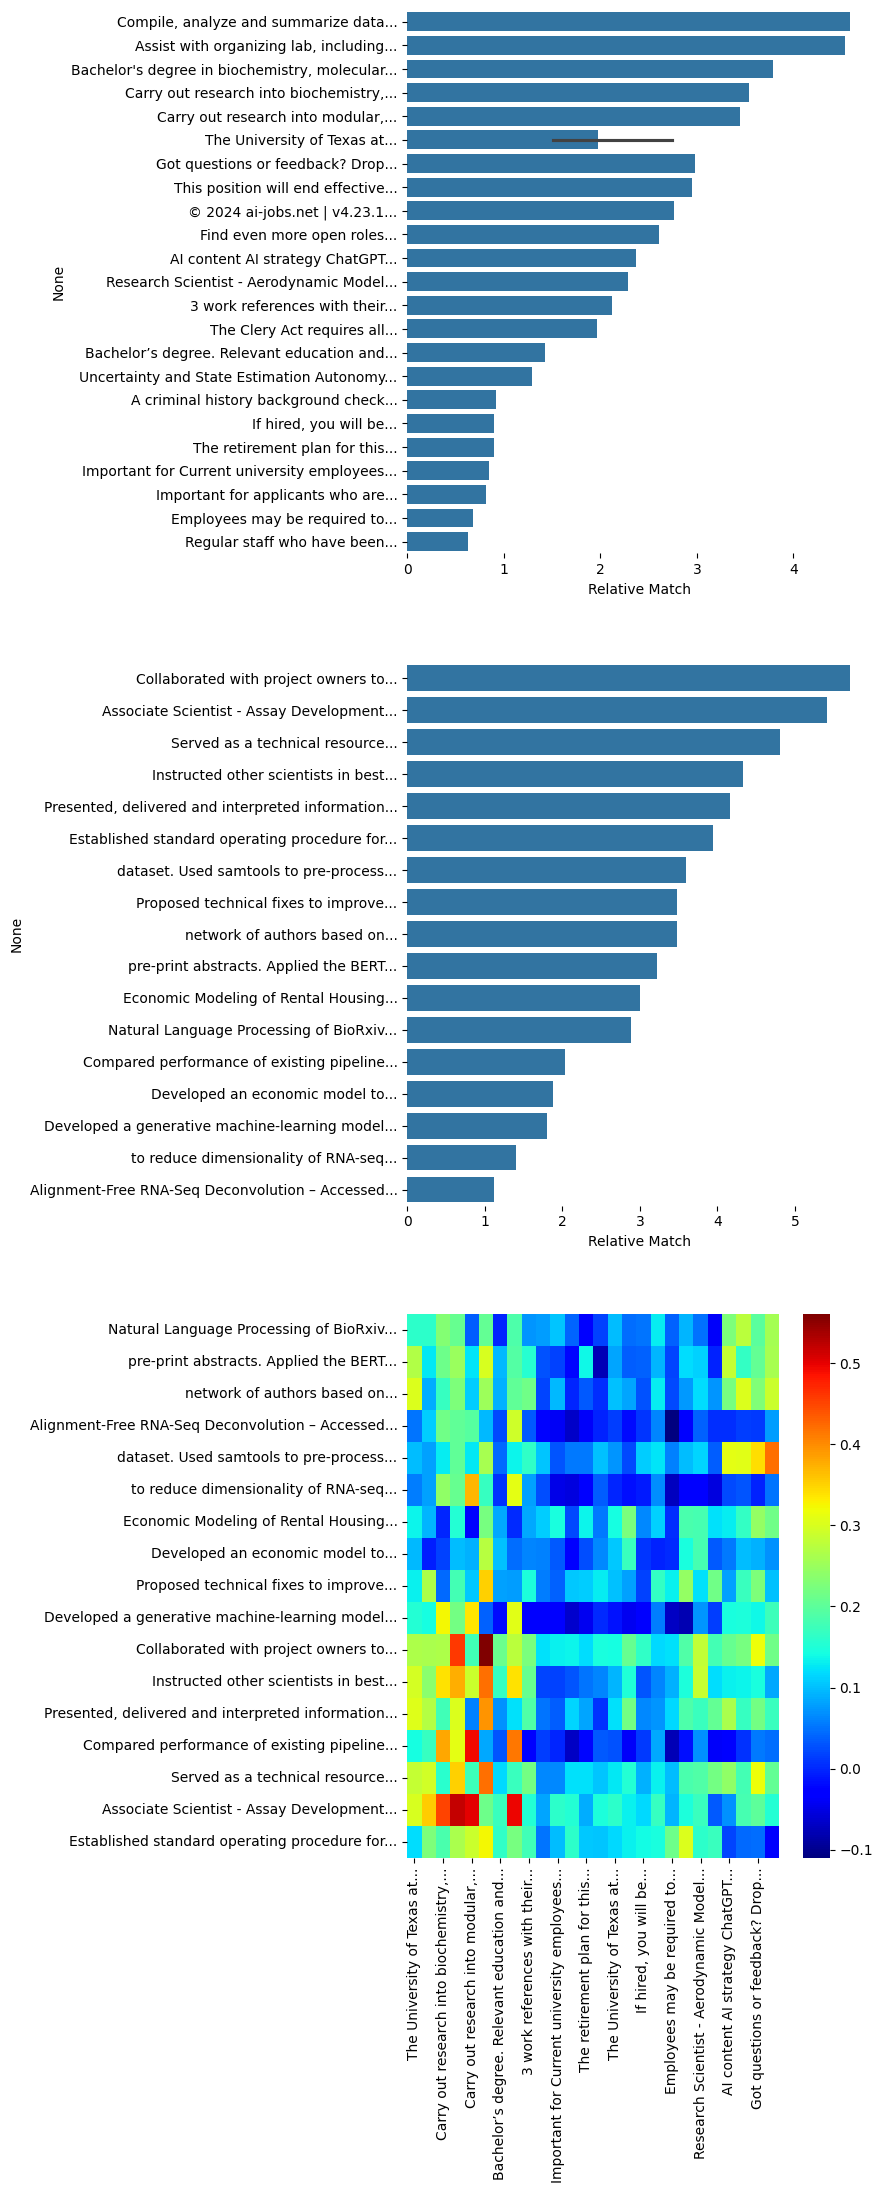

In [ ]:
matrix = hr.feature_analysis(res, df["desc"][3])
hr.plot_compare(matrix)

# Save the dataframe for later

In [ ]:
import datetime
now = datetime.datetime.strftime(datetime.datetime.now(), '%Y%m%d')
# Save it for later?
df.to_csv("Scraped_"+str(now)+".csv")

## Experimental.
Future directions?

In [ ]:
!pip install umap-learn
import umap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.8 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=ea875f2c2c83c0a9cd49e50d84299140709b6538bb0092217b8b7ddba5569415
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
# Performing a little Quality control. We know the upper jobs are good, but the lower 10% or so contain a large proportion of errors from scraping
df.drop(df[df["score"]<-2].index, inplace=True)

(array([ 18.,  35.,  71., 124.,  63.,  48.,  12.,   7.,   4.,   2.]),
 array([-1.91079982, -1.35605233, -0.80130484, -0.24655735,  0.30819014,
         0.86293763,  1.41768511,  1.9724326 ,  2.52718009,  3.08192758,
         3.63667507]),
 <BarContainer object of 10 artists>)

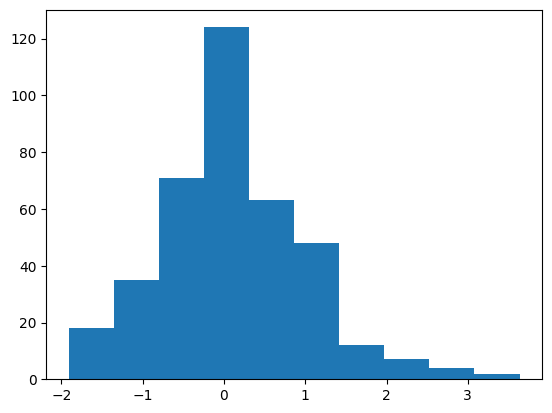

In [ ]:
plt.hist(df["score"])

In [ ]:
arr = np.zeros(len(df['encoded'][0]))
for n in df['encoded']:
    arr=np.vstack((arr,n))
arr = arr[1::]

In [ ]:
def draw_umap(data, n_neighbors=20, min_dist=0.5, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)))
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], alpha=0.1, c=df["score"], cmap='inferno')
        #for i, txt in enumerate(u):
        #    ax.annotate(df["DSI_Title"][i], (u[i,0], u[i,1]), fontsize=4)

    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], s=100)
    plt.title(title, fontsize=18)

for n in (0.1, 0.3, 0.6, 0.8):
  for m in (5, 10, 20):
    draw_umap(arr, min_dist=n, n_neighbors=m, title='min_dist = {}, n_neighbors={}'.format(n, m))

In [ ]:
n_neighbors = 30
n_components = 2
metric = 'euclidean'
min_dist=0.5
fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
u = fit.fit_transform(arr);

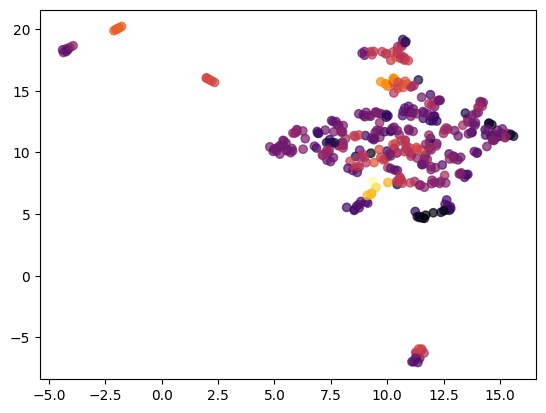

In [ ]:
plt.scatter(x=u[:,0], y=u[:,1], c=df["score"], cmap='inferno', alpha=0.7)